## Seminar 2: Transformer Architecture

Inspired by [The annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)


In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader
import warnings

from matplotlib import pyplot as plt
import seaborn as sns


# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [2]:
def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

# Part 1: Model Architecture





Most competitive neural sequence transduction models have an
encoder-decoder structure
[(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an
input sequence of symbol representations $(x_1, ..., x_n)$ to a
sequence of continuous representations $\mathbf{z} = (z_1, ...,
z_n)$. Given $\mathbf{z}$, the decoder then generates an output
sequence $(y_1,...,y_m)$ of symbols one element at a time. At each
step the model is auto-regressive
[(cite)](https://arxiv.org/abs/1308.0850), consuming the previously
generated symbols as additional input when generating the next.

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks

The Transformer follows this overall architecture using stacked
self-attention and point-wise, fully connected layers for both the
encoder and decoder.

### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [6]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [7]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection
[(cite)](https://arxiv.org/abs/1512.03385) around each of the two
sub-layers, followed by layer normalization
[(cite)](https://arxiv.org/abs/1607.06450).

In [9]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

### Example
ln = LayerNorm(128)
x = torch.randn(1, 10, 128)
ln(x).mean(-1).mean(), ln(x).std(-1).mean()


(tensor(-3.9581e-09, grad_fn=<MeanBackward0>),
 tensor(1.0000, grad_fn=<MeanBackward0>))


That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout
[(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce outputs of dimension
$d_{\text{model}}=512$.

In [10]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head
self-attention mechanism, and the second is a simple, position-wise
fully connected feed-forward network.

In [11]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.


In [12]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In addition to the two sub-layers in each encoder layer, the decoder
inserts a third sub-layer, which performs multi-head attention over
the output of the encoder stack.  Similar to the encoder, we employ
residual connections around each of the sub-layers, followed by
layer normalization.

In [13]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


We also modify the self-attention sub-layer in the decoder stack to
prevent positions from attending to subsequent positions.  This
masking, combined with fact that the output embeddings are offset by
one position, ensures that the predictions for position $i$ can
depend only on the known outputs at positions less than $i$.

In [15]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

### Example
subsequent_mask(3)

tensor([[[ True, False, False],
         [ True,  True, False],
         [ True,  True,  True]]])

### Attention

An attention function can be described as mapping a query and a set
of key-value pairs to an output, where the query, keys, values, and
output are all vectors.  The output is computed as a weighted sum of
the values, where the weight assigned to each value is computed by a
compatibility function of the query with the corresponding key.

We call our particular attention "Scaled Dot-Product Attention".
The input consists of queries and keys of dimension $d_k$, and
values of dimension $d_v$.  We compute the dot products of the query
with all keys, divide each by $\sqrt{d_k}$, and apply a softmax
function to obtain the weights on the values.


In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$


In [16]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

### Example
q = k = v = torch.ones(1, 3, 10)
attention(q, k, v)

(tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]),
 tensor([[[0.3333, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.3333],
          [0.3333, 0.3333, 0.3333]]]))


Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h=8$ parallel attention layers, or
heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due
to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.

In [19]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)  # each hidden state in splitted
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)  # (batch, seq_len, h, d_model / h)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)


### Example
mha = MultiHeadedAttention(2, 10)
q = k = v = torch.ones(1, 3, 10)
mha(q, k, v).shape


torch.Size([1, 3, 10])

### Applications of Attention in our Model

The Transformer uses multi-head attention in three different ways:
1) In "encoder-decoder attention" layers, the queries come from the
previous decoder layer, and the memory keys and values come from the
output of the encoder.  This allows every position in the decoder to
attend over all positions in the input sequence.  This mimics the
typical encoder-decoder attention mechanisms in sequence-to-sequence
models such as [(cite)](https://arxiv.org/abs/1609.08144).


2) The encoder contains self-attention layers.  In a self-attention
layer all of the keys, values and queries come from the same place,
in this case, the output of the previous layer in the encoder.  Each
position in the encoder can attend to all positions in the previous
layer of the encoder.


3) Similarly, self-attention layers in the decoder allow each
position in the decoder to attend to all positions in the decoder up
to and including that position.  We need to prevent leftward
information flow in the decoder to preserve the auto-regressive
property.  We implement this inside of scaled dot-product attention
by masking out (setting to $-\infty$) all values in the input of the
softmax which correspond to illegal connections.

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$.

In [20]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embeddings and Softmax

Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [22]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


### Example

emb_layer = Embeddings(1024, 10)
emb = emb_layer(torch.LongTensor([1, 2, 3])[None])
emb.shape, emb.mean(), emb.std()


(torch.Size([1, 3, 1024]),
 tensor(-0.3011, grad_fn=<MeanBackward0>),
 tensor(32.3632, grad_fn=<StdBackward0>))

## Positional Encoding

Since our model contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed
[(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$.



In [23]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)


### Example

pe_layer = PositionalEncoding(1024, 0.0)
x = torch.zeros(1, 10, 1024)
pe_layer(x).shape, pe_layer(x).std()


(torch.Size([1, 10, 1024]), tensor(0.5184))

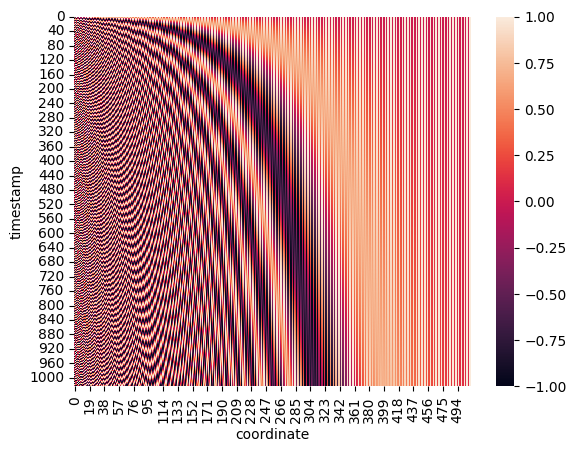

In [24]:
pe_layer = PositionalEncoding(512, 0.0, max_len=1024)
sns.heatmap(pe_layer.pe.squeeze().cpu().numpy())
plt.xlabel('coordinate')
plt.ylabel('timestamp')
plt.show()

## Full Model

Here we define a function from hyperparameters to a full model.

In [25]:
def make_model(
    src_vocab: int, tgt_vocab: int, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    generator = Generator(d_model, tgt_vocab)
    trg_embed_tokens = Embeddings(d_model, tgt_vocab)
    # share the embedding matrix
    generator.proj.weight = trg_embed_tokens.lut.weight
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(trg_embed_tokens, c(position)),
        generator,
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


## Inference:

Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next tutorial we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

In [28]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)
    
    # greedy decoding
    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


# Part 2: Model Training



We stop for a quick interlude to introduce some of the tools
needed to train a standard encoder decoder model. First we define a
batch object that holds the src and target sentences for training,
as well as constructing the masks.

## Batches and Masking

In [31]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]  # decoder inputs
            self.tgt_y = tgt[:, 1:]  # labels
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask


### Example
src = torch.LongTensor([1, 2, 3, 4, 0, 0, 0])[None]
batch = Batch(src, src, pad=0)
batch.tgt, batch.tgt_y

(tensor([[1, 2, 3, 4, 0, 0]]), tensor([[2, 3, 4, 0, 0, 0]]))


Next we create a generic training and scoring function to keep
track of loss. We pass in a generic loss compute function that
also handles parameter updates.

## Training Loop

In [32]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [33]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

## Optimizer

We used the Adam optimizer [(cite)](https://arxiv.org/abs/1412.6980)
with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We
varied the learning rate over the course of training, according to
the formula:

$$
lrate = d_{\text{model}}^{-0.5} \cdot
  \min({step\_num}^{-0.5},
    {step\_num} \cdot {warmup\_steps}^{-1.5})
$$

This corresponds to increasing the learning rate linearly for the
first $warmup\_steps$ training steps, and decreasing it thereafter
proportionally to the inverse square root of the step number.  We
used $warmup\_steps=4000$.

In [34]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

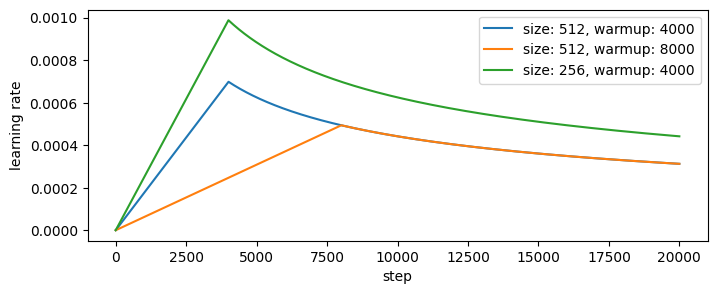

In [35]:
plt.figure(figsize=(8, 3))
opts = [
        [512, 1, 4000],  # example 1
        [512, 1, 8000],  # example 2
        [256, 1, 4000],  # example 3
    ]
dummy_model = torch.nn.Linear(1, 1)
learning_rates = []
for idx, example in enumerate(opts):
    # run 20000 epoch for each example
    optimizer = torch.optim.Adam(
        dummy_model.parameters(), lr=1, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer, lr_lambda=lambda step: rate(step, *example)
    )
    tmp = []
    # take 20K dummy training steps, save the learning rate at each step
    for step in range(20000):
        tmp.append(optimizer.param_groups[0]["lr"])
        optimizer.step()
        lr_scheduler.step()
    learning_rates.append(tmp)

for i, o in enumerate(opts):
    plt.plot(learning_rates[i], label=f'size: {o[0]}, warmup: {o[-1]}')
plt.legend()
plt.xlabel('step')
plt.ylabel('learning rate')
plt.show()

## Regularization

### Label Smoothing

During training, we employed label smoothing of value
$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567).
This hurts perplexity, as the model learns to be more unsure, but
improves accuracy and BLEU score.


We implement label smoothing using the KL div loss. Instead of
using a one-hot target distribution, we create a distribution that
has `confidence` of the correct word and the rest of the
`smoothing` mass distributed throughout the vocabulary.

In [36]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

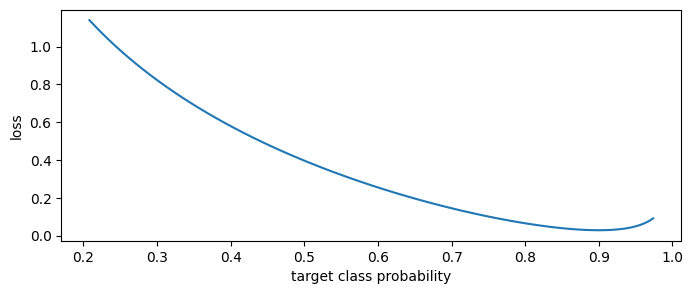

In [37]:
plt.figure(figsize=(8, 3))
crit = LabelSmoothing(5, 0, 0.1)
probs = [torch.Tensor([[0.0, x / 20, 0, 0, 0]]).log_softmax(-1) for x in range(1, 101)]
losses = [crit(p, torch.LongTensor([1])) for p in probs]
plt.plot([p.softmax(-1)[0, 1] for p in probs], losses)
plt.xlabel('target class probability')
plt.ylabel('loss')
plt.show()

## A Copy Task

We can begin by trying out a simple copy-task. Given a random set
of input symbols from a small vocabulary, the goal is to generate
back those same symbols.

### Synthetic Data

In [38]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task; seq_len=10"
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

### Loss Computation

In [39]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

### Greedy Decoding

This code predicts a translation using greedy decoding for simplicity.

In [40]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [41]:
# Train the simple copy task.


def example_simple_model():
    V = 11
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
    model = make_model(V, V, N=1, d_model=64, d_ff=256)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.1, betas=(0.9, 0.98), eps=1e-9
    )
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=50
        ),
    )

    batch_size = 64
    for epoch in range(20):
        model.train()
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5]])
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len)
    gen = greedy_decode(model, src, src_mask, max_len=max_len,
                        start_symbol=0)[0].detach().cpu().numpy()
    
    print(f'Generated: {gen}, True: {src[0].detach().cpu().numpy()}')


torch.manual_seed(0)
execute_example(example_simple_model)

Epoch Step:      1 | Accumulation Step:   2 | Loss:   6.53 | Tokens / Sec: 11956.2 | Learning Rate: 7.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   3.35 | Tokens / Sec: 14597.3 | Learning Rate: 7.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.40 | Tokens / Sec: 15197.0 | Learning Rate: 1.5e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.36 | Tokens / Sec: 15484.3 | Learning Rate: 1.6e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.33 | Tokens / Sec: 15694.0 | Learning Rate: 1.4e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.30 | Tokens / Sec: 15603.8 | Learning Rate: 1.2e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.20 | Tokens / Sec: 15667.5 | Learning Rate: 1.1e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.06 | Tokens / Sec: 15730.6 | Learning Rate: 1.0e-03
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.92 | Tokens / Sec: 15696.8 | Learning Rate: 9.8e-04
Epoch Step:      1 | Accumul

### Further Reading

* [Decoder incremental state](https://github.com/facebookresearch/fairseq/blob/main/fairseq/models/transformer/transformer_decoder.py#L190). Incremental decoding is a special mode at inference time, where the model only receives a single previous output and must produce the next output (i.e., incrementally). Thus the model must cache any long-term state that is needed about the sequence, e.g., hidden states, convolutional states, etc.
